# IFACO Multi-Objective Optimization
## Vehicle Routing Problem with Time Windows + CO₂ Emissions


---
## Import Required Modules

In [49]:

from ifaco_core_co2 import *
from afsa import ArtificialFishSwarmAlgorithm
from aco import ImprovedAntColonyOptimization
from ifaco_comparison_viz import ComparisonVisualizer
import json
import time
import numpy as np
import matplotlib.pyplot as plt

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ All modules imported successfully!")
print("Ready to start optimization...")

✅ All modules imported successfully!
Ready to start optimization...


---
## 📊 Load Instance and Configure Parameters


In [50]:
# Configuration
instance_file = 'C101_sample.txt'
emission_factor = 0.05  # γ (kg CO₂ per km per unit load)
lambda_distance = 1.0   # Weight for distance objective
lambda_emission = 1.0   # Weight for emission objective

# Set global weights
ArtificialFish.LAMBDA_DISTANCE = lambda_distance
ArtificialFish.LAMBDA_EMISSION = lambda_emission

from aco import Ant
Ant.LAMBDA_DISTANCE = lambda_distance
Ant.LAMBDA_EMISSION = lambda_emission

# Load instance
instance = SolomonDataLoader.load_solomon_instance(instance_file, emission_factor)

print("\n" + "="*60)
print("INSTANCE LOADED")
print("="*60)
print(f"Instance name: {instance.name}")
print(f"Number of customers: {len(instance.customers)}")
print(f"Vehicle capacity: {instance.vehicle_capacity}")
print(f"Max vehicles: {instance.num_vehicles}")
print(f"\n🌍 Emission factor: {instance.emission_factor} kg CO₂/(km·unit load)")
print(f"⚖️  Multi-objective weights:")
print(f"   λ_distance = {lambda_distance}")
print(f"   λ_emission = {lambda_emission}")
print(f"\n📐 Fitness = {lambda_distance}×Distance + {lambda_emission}×Emissions")

Loading instance: C101_sample.txt
Found customer data starting at line 6
Loaded 101 customers
Using default values: 25 vehicles, capacity 200
🌍 CO₂ emission factor (γ): 0.05 kg CO₂ per km per unit load

INSTANCE LOADED
Instance name: C101
Number of customers: 101
Vehicle capacity: 200
Max vehicles: 25

🌍 Emission factor: 0.05 kg CO₂/(km·unit load)
⚖️  Multi-objective weights:
   λ_distance = 1.0
   λ_emission = 1.0

📐 Fitness = 1.0×Distance + 1.0×Emissions


---
## 🔍 Sample Instance Data 
View customer locations and demands.


First 10 Customers:
ID           X        Y   Demand    Ready      Due  Service
--------------------------------------------------------------------------------
0        40.00    50.00        0        0     1236        0
1        45.00    68.00       10      912      967       90
2        45.00    70.00       30      825      870       90
3        42.00    66.00       10       65      146       90
4        42.00    68.00       10      727      782       90
5        42.00    65.00       10       15       67       90
6        40.00    69.00       20      621      702       90
7        40.00    66.00       20      170      225       90
8        38.00    68.00       20      255      324       90
9        38.00    70.00       10      534      605       90

Total demand: 1810
Minimum vehicles needed: 10


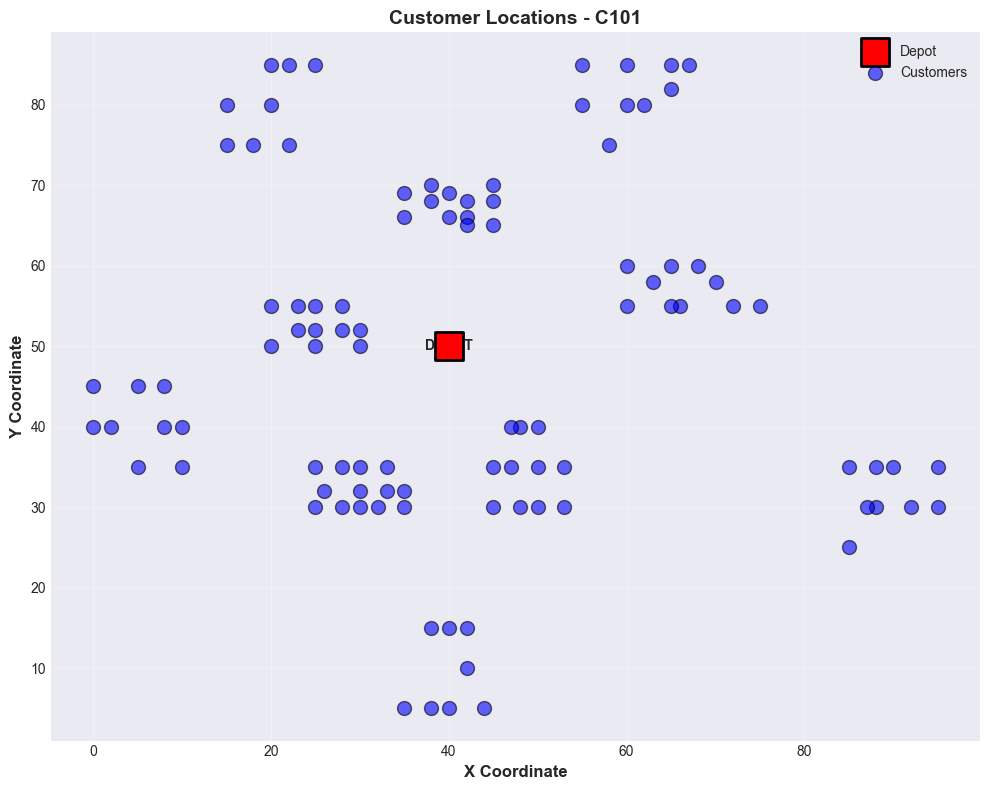


✅ Instance data inspected!


In [51]:
# Display first 10 customers
print("\nFirst 10 Customers:")
print("="*80)
print(f"{'ID':<5} {'X':>8} {'Y':>8} {'Demand':>8} {'Ready':>8} {'Due':>8} {'Service':>8}")
print("-"*80)

for i, customer in enumerate(instance.customers[:10]):
    print(f"{customer.id:<5} {customer.x:>8.2f} {customer.y:>8.2f} "
          f"{customer.demand:>8} {customer.ready_time:>8} "
          f"{customer.due_time:>8} {customer.service_time:>8}")

# Calculate total demand
total_demand = sum(c.demand for c in instance.customers[1:])
print(f"\nTotal demand: {total_demand}")
print(f"Minimum vehicles needed: {np.ceil(total_demand / instance.vehicle_capacity):.0f}")

# Plot customer locations
fig, ax = plt.subplots(figsize=(10, 8))
depot = instance.customers[0]
customers = instance.customers[1:]

# Plot depot
ax.scatter(depot.x, depot.y, c='red', s=400, marker='s', 
          edgecolors='black', linewidths=2, zorder=5, label='Depot')
ax.annotate('DEPOT', (depot.x, depot.y), fontsize=10, fontweight='bold',
           ha='center', va='center')

# Plot customers
x_coords = [c.x for c in customers]
y_coords = [c.y for c in customers]
ax.scatter(x_coords, y_coords, c='blue', s=100, alpha=0.6, 
          edgecolors='black', linewidths=1, label='Customers')

ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
ax.set_title(f'Customer Locations - {instance.name}', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Instance data inspected!")

---
##  Standalone AFSA
Run Artificial Fish Swarm Algorithm independently (no ACO refinement).

In [59]:
print("\n" + "="*80)
print("RUNNING STANDALONE AFSA")
print("Fish Swarm Optimization Only (No ACO Refinement)")
print("="*80)

# Algorithm parameters
fish_count = 50
afsa_iterations = 30

print(f"\nParameters: {fish_count} fish, {afsa_iterations} iterations")
print("Starting optimization...\n")

afsa_start = time.time()

# Create and run AFSA
afsa = ArtificialFishSwarmAlgorithm(
    instance,
    fish_count=fish_count,
    max_iterations=afsa_iterations
)

afsa_best_fish = afsa.run()
afsa_time = time.time() - afsa_start

# Calculate emissions
afsa_emissions = EmissionCalculator.calculate_solution_emissions(
    afsa_best_fish.position, instance
)

# Store results
afsa_results = {
    'fitness': afsa_best_fish.fitness,
    'distance': afsa_best_fish.total_distance,
    'emission': afsa_best_fish.total_emission,
    'routes': afsa_best_fish.position,
    'num_routes': len([r for r in afsa_best_fish.position if r]),
    'time': afsa_time,
    'history': afsa.fitness_history
}

print("\n" + "="*80)
print("✅ STANDALONE AFSA RESULTS")
print("="*80)
print(f"Multi-objective fitness: {afsa_best_fish.fitness:.2f}")
print(f"  └─ Distance: {afsa_best_fish.total_distance:.2f} km")
print(f"  └─ Emissions: {afsa_best_fish.total_emission:.2f} kg CO₂")
print(f"Number of routes: {afsa_results['num_routes']}")
print(f"Execution time: {afsa_time:.2f} seconds")


print("\n✅ Standalone AFSA completed!")


RUNNING STANDALONE AFSA
Fish Swarm Optimization Only (No ACO Refinement)

Parameters: 50 fish, 30 iterations
Starting optimization...

Running MULTI-OBJECTIVE AFSA with 50 fish for 30 iterations...
Fitness = 1.0×Distance + 1.0×Emissions
AFSA Iteration 0: Best fitness = 19771.95
  └─ Distance: 3766.68 km, Emissions: 16005.27 kg CO₂
AFSA Iteration 15: Best fitness = 14151.24
  └─ Distance: 2990.63 km, Emissions: 11160.61 kg CO₂

AFSA completed. Final best fitness: 12532.30
  Distance: 2622.37 km
  Emissions: 9909.93 kg CO₂

✅ STANDALONE AFSA RESULTS
Multi-objective fitness: 12532.30
  └─ Distance: 2622.37 km
  └─ Emissions: 9909.93 kg CO₂
Number of routes: 10
Execution time: 11.25 seconds

✅ Standalone AFSA completed!


---
## 🐜 Run Standalone ACO
Run Ant Colony Optimization independently with DEFAULT initialization (no AFSA).

In [60]:
print("\n" + "="*80)
print("RUNNING STANDALONE ACO")
print("Ant Colony Optimization Only (Default Pheromone Initialization)")
print("="*80)

# Algorithm parameters
num_ants = 100
aco_iterations = 50
alpha = 1.0
beta = 3.0
lamda = 1.5
rho = 0.25
q = 100.0

print(f"\nParameters: {num_ants} ants, {aco_iterations} iterations")
print(f"α={alpha}, β={beta}, λ={lamda}, ρ={rho}, q={q}")
print("\nStarting with DEFAULT pheromone (uniform 0.1)...\n")

aco_start = time.time()

# Create and run ACO
aco = ImprovedAntColonyOptimization(
    instance,
    num_ants=num_ants,
    max_iterations=aco_iterations,
    alpha=alpha,
    beta=beta,
    lamda=lamda,
    rho=rho,
    q=q
)

aco_best_ant = aco.run()
aco_time = time.time() - aco_start

if aco_best_ant:
    # Calculate emissions
    aco_emissions = EmissionCalculator.calculate_solution_emissions(
        aco_best_ant.routes, instance
    )
    
    # Store results
    aco_results = {
        'fitness': aco_best_ant.fitness,
        'distance': aco_best_ant.total_distance,
        'emission': aco_best_ant.total_emission,
        'routes': aco_best_ant.routes,
        'num_routes': len([r for r in aco_best_ant.routes if r]),
        'time': aco_time,
        'history': aco.iteration_best_fitnesses
    }
    
    print("\n" + "="*80)
    print("✅ STANDALONE ACO RESULTS")
    print("="*80)
    print(f"Multi-objective fitness: {aco_best_ant.fitness:.2f}")
    print(f"  └─ Distance: {aco_best_ant.total_distance:.2f} km")
    print(f"  └─ Emissions: {aco_best_ant.total_emission:.2f} kg CO₂")
    print(f"Number of routes: {aco_results['num_routes']}")
    print(f"Execution time: {aco_time:.2f} seconds")
    
    


RUNNING STANDALONE ACO
Ant Colony Optimization Only (Default Pheromone Initialization)

Parameters: 100 ants, 50 iterations
α=1.0, β=3.0, λ=1.5, ρ=0.25, q=100.0

Starting with DEFAULT pheromone (uniform 0.1)...

Running MULTI-OBJECTIVE ACO with 100 ants for 50 iterations...
Parameters: α=1.0, β=3.0, λ=1.5, ρ=0.25
Fitness = 1.0×Distance + 1.0×Emissions
Iteration 0: New best fitness = 4987.70
  └─ Distance: 1443.38 km, Emissions: 3544.32 kg CO₂
Iteration 0: Current best fitness = 4987.70
Iteration 1: New best fitness = 4758.09
  └─ Distance: 1209.34 km, Emissions: 3548.75 kg CO₂
Iteration 2: New best fitness = 4648.03
  └─ Distance: 1248.14 km, Emissions: 3399.89 kg CO₂
Iteration 4: New best fitness = 4553.16
  └─ Distance: 1174.77 km, Emissions: 3378.39 kg CO₂
Iteration 5: New best fitness = 4425.35
  └─ Distance: 1019.05 km, Emissions: 3406.31 kg CO₂
Iteration 7: New best fitness = 4408.23
  └─ Distance: 936.03 km, Emissions: 3472.19 kg CO₂
Iteration 8: New best fitness = 4388.54
  └─

---
## 🔄 Cell 6: Run Hybrid IFACO

In [61]:
print("\n" + "="*80)
print("RUNNING HYBRID IFACO")
print("ACO Initialized with AFSA Solution")
print("="*80)

print(f"\nUsing AFSA solution (fitness: {afsa_best_fish.fitness:.2f}) to initialize ACO...")
print("Starting hybrid optimization...\n")

hybrid_start = time.time()

# Create ACO
hybrid_aco = ImprovedAntColonyOptimization(
    instance,
    num_ants=num_ants,
    max_iterations=aco_iterations,
    alpha=alpha,
    beta=beta,
    lamda=lamda,
    rho=rho,
    q=q
)

# Initialize pheromone from AFSA
hybrid_aco.initialize_pheromone_from_afsa(afsa_best_fish)

# Run ACO
hybrid_best_ant = hybrid_aco.run()
hybrid_time = time.time() - hybrid_start

# Add AFSA time for total hybrid time
total_hybrid_time = afsa_time + hybrid_time

if hybrid_best_ant:
    # Calculate emissions
    hybrid_emissions = EmissionCalculator.calculate_solution_emissions(
        hybrid_best_ant.routes, instance
    )
    
    # Store results
    hybrid_results = {
        'fitness': hybrid_best_ant.fitness,
        'distance': hybrid_best_ant.total_distance,
        'emission': hybrid_best_ant.total_emission,
        'routes': hybrid_best_ant.routes,
        'num_routes': len([r for r in hybrid_best_ant.routes if r]),
        'time': total_hybrid_time,
        'history': hybrid_aco.iteration_best_fitnesses
    }
    
    print("\n" + "="*80)
    print("✅ HYBRID IFACO RESULTS")
    print("="*80)
    print(f"Multi-objective fitness: {hybrid_best_ant.fitness:.2f}")
    print(f"  └─ Distance: {hybrid_best_ant.total_distance:.2f} km")
    print(f"  └─ Emissions: {hybrid_best_ant.total_emission:.2f} kg CO₂")
    print(f"Number of routes: {hybrid_results['num_routes']}")
    print(f"ACO execution time: {hybrid_time:.2f} seconds")
    print(f"Total hybrid time (AFSA + ACO): {total_hybrid_time:.2f} seconds")
 


RUNNING HYBRID IFACO
ACO Initialized with AFSA Solution

Using AFSA solution (fitness: 12532.30) to initialize ACO...
Starting hybrid optimization...

Initialized ACO pheromone from AFSA (multi-objective fitness: 12532.30)
  └─ AFSA Distance: 2622.37 km, Emissions: 9909.93 kg CO₂
Running MULTI-OBJECTIVE ACO with 100 ants for 50 iterations...
Parameters: α=1.0, β=3.0, λ=1.5, ρ=0.25
Fitness = 1.0×Distance + 1.0×Emissions
Iteration 0: New best fitness = 4769.08
  └─ Distance: 1265.09 km, Emissions: 3503.99 kg CO₂
Iteration 0: Current best fitness = 4769.08
Iteration 3: New best fitness = 4652.39
  └─ Distance: 1207.47 km, Emissions: 3444.93 kg CO₂
Iteration 4: New best fitness = 4549.90
  └─ Distance: 1024.63 km, Emissions: 3525.27 kg CO₂
Iteration 5: New best fitness = 4452.90
  └─ Distance: 1038.38 km, Emissions: 3414.52 kg CO₂
Iteration 6: New best fitness = 4418.99
  └─ Distance: 898.32 km, Emissions: 3520.67 kg CO₂
Iteration 7: New best fitness = 4364.66
  └─ Distance: 850.25 km, Em

---
## 📊 Compare All Three Variants
Side-by-side comparison of AFSA, ACO, and Hybrid IFACO.

In [62]:
print("\n" + "="*80)
print("🏆 COMPREHENSIVE COMPARISON")
print("="*80)

# Comparison table
print(f"\n{'Metric':<25} {'AFSA':<18} {'ACO':<18} {'Hybrid':<18} {'Best':<12}")
print("-" * 100)

# Fitness
fitness_vals = [afsa_results['fitness']]
if aco_results:
    fitness_vals.append(aco_results['fitness'])
else:
    fitness_vals.append(float('inf'))
if hybrid_results:
    fitness_vals.append(hybrid_results['fitness'])
else:
    fitness_vals.append(float('inf'))

best_idx = fitness_vals.index(min(fitness_vals))
labels = ['AFSA', 'ACO', 'Hybrid']
row = f"{'Multi-obj Fitness':<25}"
for i, val in enumerate(fitness_vals):
    marker = ' ⭐' if i == best_idx and val != float('inf') else '   '
    if val != float('inf'):
        row += f"{val:>15.2f}{marker} "
    else:
        row += f"{'N/A':>15}{marker} "
row += labels[best_idx]
print(row)

# Distance
dist_vals = [afsa_results['distance']]
if aco_results:
    dist_vals.append(aco_results['distance'])
else:
    dist_vals.append(float('inf'))
if hybrid_results:
    dist_vals.append(hybrid_results['distance'])
else:
    dist_vals.append(float('inf'))

best_idx = dist_vals.index(min(dist_vals))
row = f"{'Distance (km)':<25}"
for i, val in enumerate(dist_vals):
    marker = ' ⭐' if i == best_idx and val != float('inf') else '   '
    if val != float('inf'):
        row += f"{val:>15.2f}{marker} "
    else:
        row += f"{'N/A':>15}{marker} "
row += labels[best_idx]
print(row)

# Emissions
emis_vals = [afsa_results['emission']]
if aco_results:
    emis_vals.append(aco_results['emission'])
else:
    emis_vals.append(float('inf'))
if hybrid_results:
    emis_vals.append(hybrid_results['emission'])
else:
    emis_vals.append(float('inf'))

best_idx = emis_vals.index(min(emis_vals))
row = f"{'Emissions (kg CO₂)':<25}"
for i, val in enumerate(emis_vals):
    marker = ' ⭐' if i == best_idx and val != float('inf') else '   '
    if val != float('inf'):
        row += f"{val:>15.2f}{marker} "
    else:
        row += f"{'N/A':>15}{marker} "
row += labels[best_idx]
print(row)

# Routes
route_vals = [afsa_results['num_routes']]
if aco_results:
    route_vals.append(aco_results['num_routes'])
else:
    route_vals.append(999)
if hybrid_results:
    route_vals.append(hybrid_results['num_routes'])
else:
    route_vals.append(999)

best_idx = route_vals.index(min(route_vals))
row = f"{'Number of Routes':<25}"
for i, val in enumerate(route_vals):
    marker = ' ⭐' if i == best_idx and val != 999 else '   '
    if val != 999:
        row += f"{val:>15d}{marker} "
    else:
        row += f"{'N/A':>15}{marker} "
row += labels[best_idx]
print(row)







🏆 COMPREHENSIVE COMPARISON

Metric                    AFSA               ACO                Hybrid             Best        
----------------------------------------------------------------------------------------------------
Multi-obj Fitness               12532.30            4339.72            4337.06 ⭐ Hybrid
Distance (km)                    2622.37             891.16             882.74 ⭐ Hybrid
Emissions (kg CO₂)               9909.93            3448.57 ⭐         3454.31    ACO
Number of Routes                      10 ⭐              12                 12    AFSA


---
## 📈 Plot Convergence Comparison
Compare convergence behavior of all three variants.

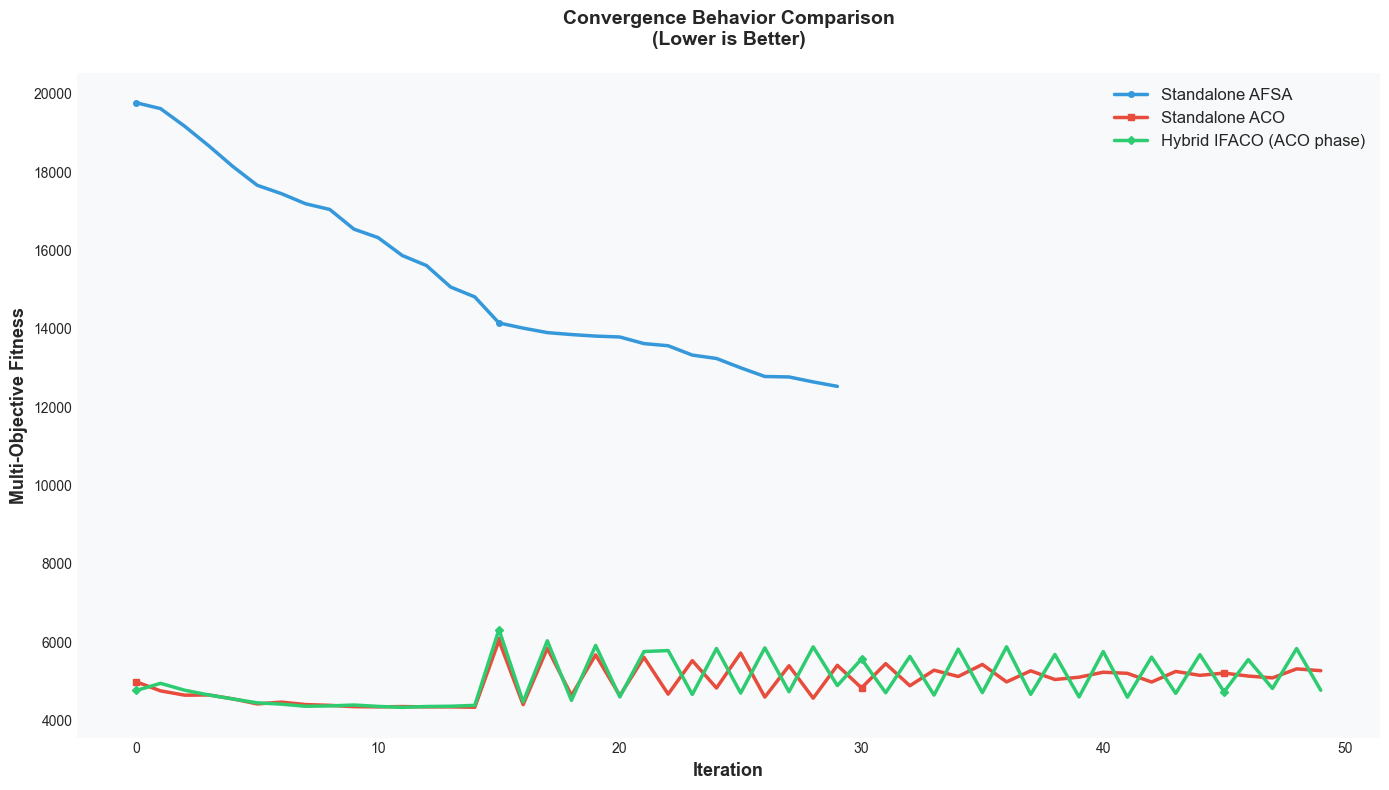

✅ Convergence comparison plotted!


In [63]:
fig, ax = plt.subplots(figsize=(14, 8))

# AFSA
ax.plot(afsa_results['history'], label='Standalone AFSA', 
       color='#3498db', linewidth=2.5, marker='o', markersize=4, markevery=15)

# ACO
if aco_results:
    history_filtered = [f for f in aco_results['history'] if f != float('inf')]
    ax.plot(history_filtered, label='Standalone ACO',
           color='#e74c3c', linewidth=2.5, marker='s', markersize=4, markevery=15)

# Hybrid
if hybrid_results:
    history_filtered = [f for f in hybrid_results['history'] if f != float('inf')]
    ax.plot(history_filtered, label='Hybrid IFACO (ACO phase)',
           color='#2ecc71', linewidth=2.5, marker='D', markersize=4, markevery=15)

ax.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax.set_ylabel('Multi-Objective Fitness', fontsize=13, fontweight='bold')
ax.set_title('Convergence Behavior Comparison\n(Lower is Better)',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

print("✅ Convergence comparison plotted!")

---
## 🗺️Visualize AFSA Routes
Show customer nodes and vehicle routes for AFSA solution.

C:\Users\gargp\AppData\Local\Temp\ipykernel_12644\542044580.py:55: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\gargp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


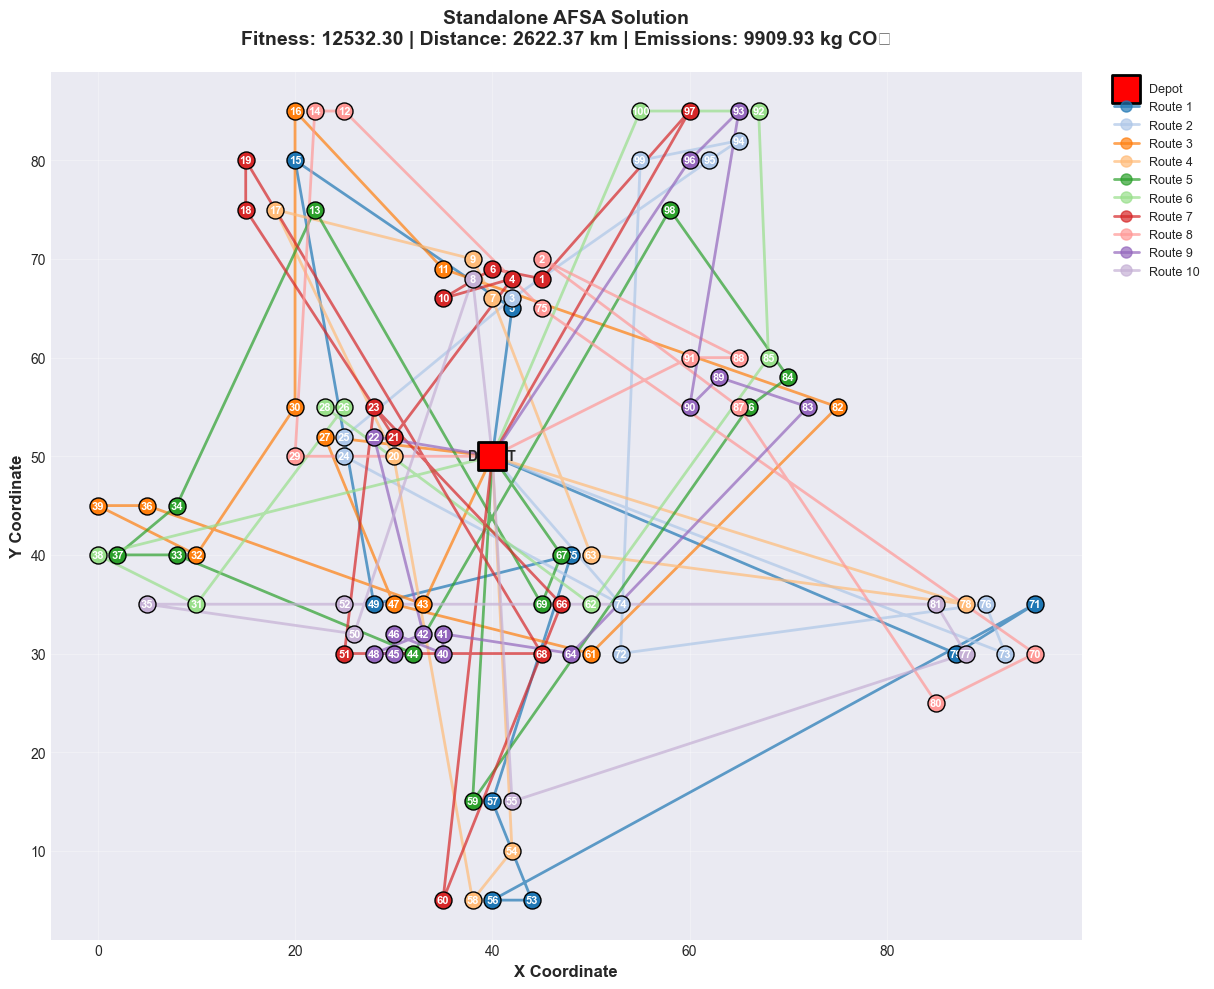

✅ AFSA routes visualized!


In [64]:
fig, ax = plt.subplots(figsize=(14, 10))

routes = afsa_results['routes']
colors = plt.cm.tab20(np.linspace(0, 1, 20))

# Plot depot
depot = instance.customers[0]
ax.scatter(depot.x, depot.y, c='red', s=400, marker='s', 
          edgecolors='black', linewidths=2, zorder=5, label='Depot')
ax.annotate('DEPOT', (depot.x, depot.y), fontsize=10, fontweight='bold',
           ha='center', va='center')

# Plot each route
for i, route in enumerate(routes):
    if not route:
        continue
    
    color = colors[i % len(colors)]
    
    # Build route coordinates
    route_x = [depot.x]
    route_y = [depot.y]
    
    for customer_id in route:
        customer = instance.customers[customer_id]
        route_x.append(customer.x)
        route_y.append(customer.y)
    
    route_x.append(depot.x)
    route_y.append(depot.y)
    
    # Plot route
    ax.plot(route_x, route_y, 'o-', color=color, linewidth=2, 
           markersize=8, alpha=0.7, label=f'Route {i+1}')
    
    # Plot customers
    for customer_id in route:
        customer = instance.customers[customer_id]
        ax.scatter(customer.x, customer.y, c=[color], s=150, 
                  edgecolors='black', linewidths=1, zorder=3)
        ax.annotate(str(customer_id), (customer.x, customer.y),
                   fontsize=8, ha='center', va='center', 
                   fontweight='bold', color='white')

ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
ax.set_title(f'Standalone AFSA Solution\n'
            f'Fitness: {afsa_results["fitness"]:.2f} | '
            f'Distance: {afsa_results["distance"]:.2f} km | '
            f'Emissions: {afsa_results["emission"]:.2f} kg CO₂',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

print("✅ AFSA routes visualized!")

---
## 🗺️  Visualize ACO Routes
Show customer nodes and vehicle routes for standalone ACO solution.

C:\Users\gargp\AppData\Local\Temp\ipykernel_12644\1273486960.py:56: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


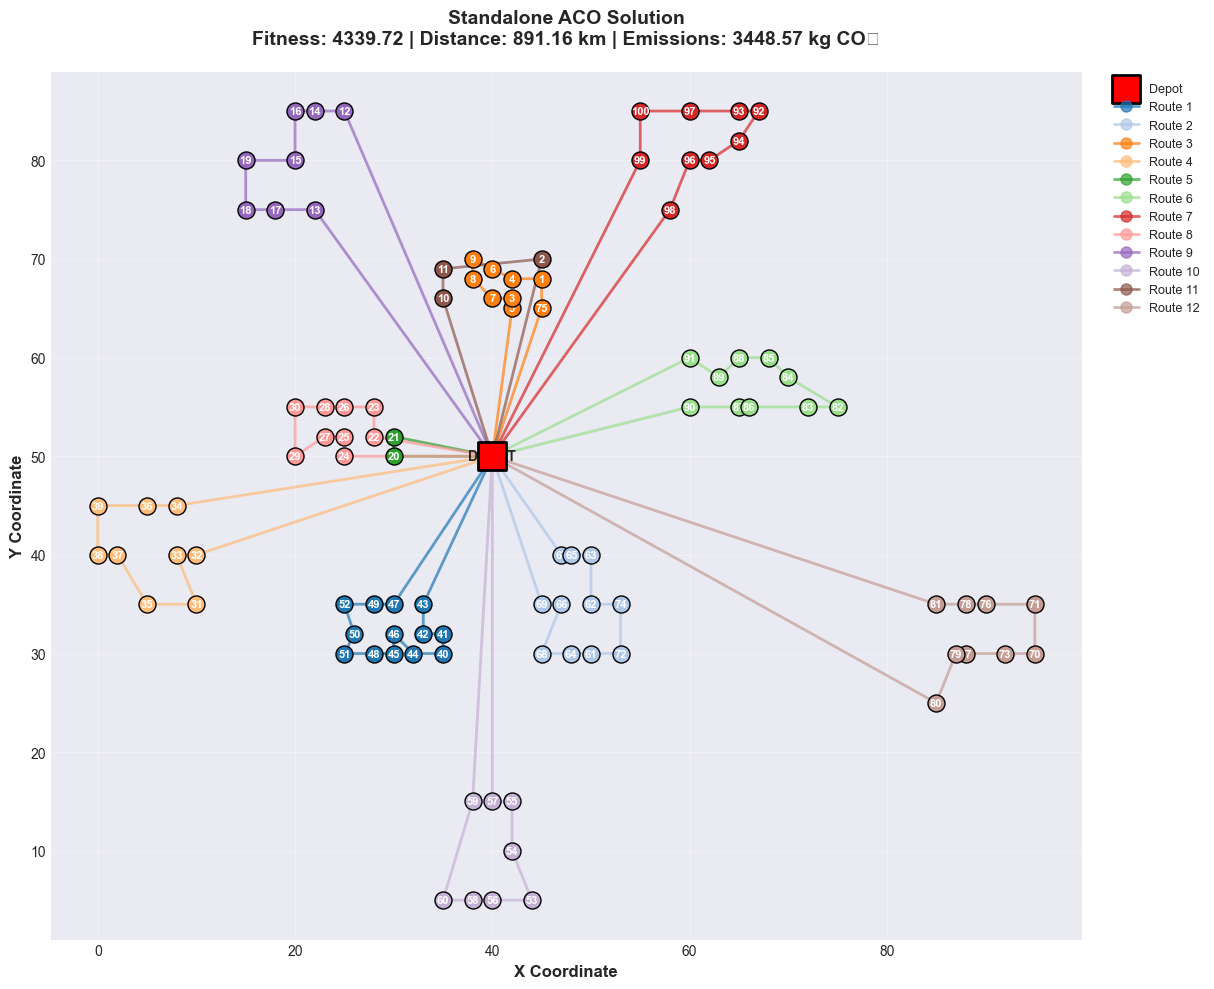

✅ Standalone ACO routes visualized!


In [65]:
if aco_results:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    routes = aco_results['routes']
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    
    # Plot depot
    depot = instance.customers[0]
    ax.scatter(depot.x, depot.y, c='red', s=400, marker='s', 
              edgecolors='black', linewidths=2, zorder=5, label='Depot')
    ax.annotate('DEPOT', (depot.x, depot.y), fontsize=10, fontweight='bold',
               ha='center', va='center')
    
    # Plot each route
    for i, route in enumerate(routes):
        if not route:
            continue
        
        color = colors[i % len(colors)]
        
        # Build route coordinates
        route_x = [depot.x]
        route_y = [depot.y]
        
        for customer_id in route:
            customer = instance.customers[customer_id]
            route_x.append(customer.x)
            route_y.append(customer.y)
        
        route_x.append(depot.x)
        route_y.append(depot.y)
        
        # Plot route
        ax.plot(route_x, route_y, 'o-', color=color, linewidth=2, 
               markersize=8, alpha=0.7, label=f'Route {i+1}')
        
        # Plot customers
        for customer_id in route:
            customer = instance.customers[customer_id]
            ax.scatter(customer.x, customer.y, c=[color], s=150, 
                      edgecolors='black', linewidths=1, zorder=3)
            ax.annotate(str(customer_id), (customer.x, customer.y),
                       fontsize=8, ha='center', va='center', 
                       fontweight='bold', color='white')
    
    ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
    ax.set_title(f'Standalone ACO Solution\n'
                f'Fitness: {aco_results["fitness"]:.2f} | '
                f'Distance: {aco_results["distance"]:.2f} km | '
                f'Emissions: {aco_results["emission"]:.2f} kg CO₂',
                fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()
    
    print("✅ Standalone ACO routes visualized!")
else:
    print("⚠️ No ACO results to visualize")

---
## 🗺️  Visualize Hybrid IFACO Routes
Show customer nodes and vehicle routes for hybrid solution.

C:\Users\gargp\AppData\Local\Temp\ipykernel_12644\1826436193.py:56: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


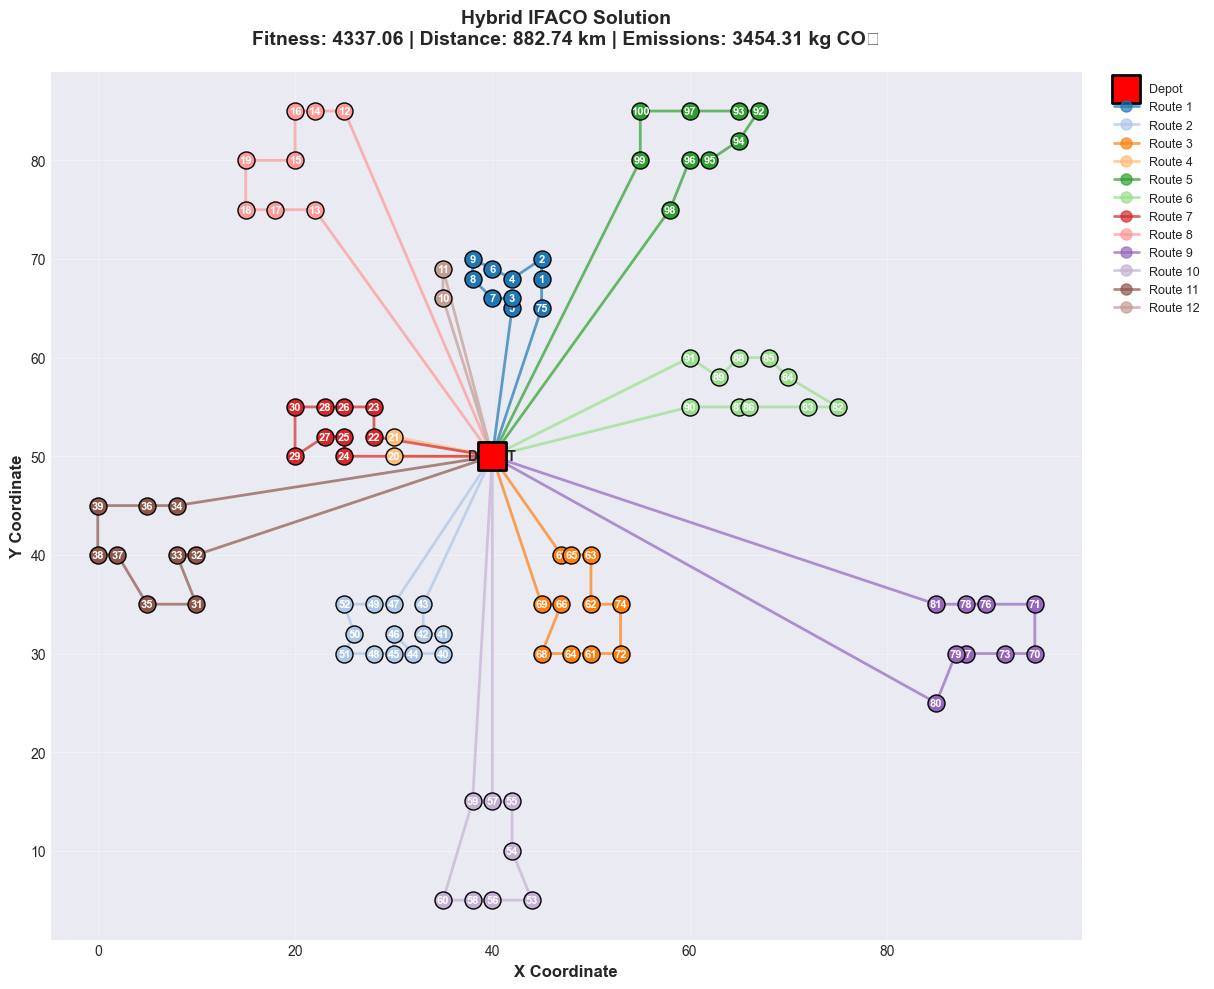

✅ Hybrid IFACO routes visualized!


In [66]:
if hybrid_results:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    routes = hybrid_results['routes']
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    
    # Plot depot
    depot = instance.customers[0]
    ax.scatter(depot.x, depot.y, c='red', s=400, marker='s', 
              edgecolors='black', linewidths=2, zorder=5, label='Depot')
    ax.annotate('DEPOT', (depot.x, depot.y), fontsize=10, fontweight='bold',
               ha='center', va='center')
    
    # Plot each route
    for i, route in enumerate(routes):
        if not route:
            continue
        
        color = colors[i % len(colors)]
        
        # Build route coordinates
        route_x = [depot.x]
        route_y = [depot.y]
        
        for customer_id in route:
            customer = instance.customers[customer_id]
            route_x.append(customer.x)
            route_y.append(customer.y)
        
        route_x.append(depot.x)
        route_y.append(depot.y)
        
        # Plot route
        ax.plot(route_x, route_y, 'o-', color=color, linewidth=2, 
               markersize=8, alpha=0.7, label=f'Route {i+1}')
        
        # Plot customers
        for customer_id in route:
            customer = instance.customers[customer_id]
            ax.scatter(customer.x, customer.y, c=[color], s=150, 
                      edgecolors='black', linewidths=1, zorder=3)
            ax.annotate(str(customer_id), (customer.x, customer.y),
                       fontsize=8, ha='center', va='center', 
                       fontweight='bold', color='white')
    
    ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
    ax.set_title(f'Hybrid IFACO Solution\n'
                f'Fitness: {hybrid_results["fitness"]:.2f} | '
                f'Distance: {hybrid_results["distance"]:.2f} km | '
                f'Emissions: {hybrid_results["emission"]:.2f} kg CO₂',
                fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()
    
    print("✅ Hybrid IFACO routes visualized!")
else:
    print("⚠️ No Hybrid results to visualize")

---
## 💾 Save Results to JSON
Save all results for later analysis.

In [67]:
def convert_to_serializable(obj):
    """Convert numpy types to JSON-compatible types"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Prepare results dictionary
all_results = {
    'instance_name': instance.name,
    'emission_factor': instance.emission_factor,
    'multi_objective_weights': {
        'lambda_distance': lambda_distance,
        'lambda_emission': lambda_emission
    },
    'standalone_afsa': convert_to_serializable(afsa_results),
    'standalone_aco': convert_to_serializable(aco_results) if aco_results else {'error': 'Failed'},
    'hybrid_ifaco': convert_to_serializable(hybrid_results) if hybrid_results else {'error': 'Failed'}
}

# Save to file
output_file = 'notebook_comparison_results.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"✅ Results saved to {output_file}")
print(f"\nYou can load these results later using:")
print(f"  with open('{output_file}', 'r') as f:")
print(f"      results = json.load(f)")

✅ Results saved to notebook_comparison_results.json

You can load these results later using:
  with open('notebook_comparison_results.json', 'r') as f:
      results = json.load(f)


---
## 📝  Summary and Conclusions
Display final summary and recommendations.

In [68]:
print("\n" + "="*80)
print("📋 FINAL SUMMARY AND CONCLUSIONS")
print("="*80)

print("\n✅ Successfully ran all three variants:")
print(f"   1. Standalone AFSA: Fitness = {afsa_results['fitness']:.2f}")
if aco_results:
    print(f"   2. Standalone ACO: Fitness = {aco_results['fitness']:.2f}")
else:
    print(f"   2. Standalone ACO: Failed")
if hybrid_results:
    print(f"   3. Hybrid IFACO: Fitness = {hybrid_results['fitness']:.2f}")
else:
    print(f"   3. Hybrid IFACO: Failed")

print("\n🎯 Best Overall Solution:")
best_fitness = min([afsa_results['fitness']] + 
                  ([aco_results['fitness']] if aco_results else []) +
                  ([hybrid_results['fitness']] if hybrid_results else []))

if best_fitness == afsa_results['fitness']:
    print("   -> Standalone AFSA")
elif aco_results and best_fitness == aco_results['fitness']:
    print("   -> Standalone ACO")
elif hybrid_results and best_fitness == hybrid_results['fitness']:
    print("   -> Hybrid IFACO")

print(f"   Fitness: {best_fitness:.2f}")

print("\n")
if aco_results and hybrid_results:
    imp = ((aco_results['fitness'] - hybrid_results['fitness']) / aco_results['fitness']) * 100
    if imp > 2:
        print(f"   ✅ Use Hybrid IFACO for best quality ({imp:.2f}% better than standalone ACO)")
    elif imp > 0:
        print(f"   Hybrid provides marginal improvement ({imp:.2f}%)")
    else:
        print(f"   ✅ Use Standalone ACO (hybrid provides no benefit)")
        print(f"   → Save computational time")
elif aco_results:
    print("   ✅ Use Standalone ACO (hybrid failed)")
else:
    print("   ✅ Use Standalone AFSA (ACO variants failed)")




📋 FINAL SUMMARY AND CONCLUSIONS

✅ Successfully ran all three variants:
   1. Standalone AFSA: Fitness = 12532.30
   2. Standalone ACO: Fitness = 4339.72
   3. Hybrid IFACO: Fitness = 4337.06

🎯 Best Overall Solution:
   -> Hybrid IFACO
   Fitness: 4337.06


   Hybrid provides marginal improvement (0.06%)
